In [2]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime

In [3]:
N = norm.cdf


In [4]:
def read_from_db():
    conn = sqlite3.connect('../../options_database.db')
    df = pd.read_sql_query("SELECT * FROM options_table", conn)
    conn.close()
    return df

In [5]:
df = read_from_db()

In [6]:
len(df[(df.current_time == '2023-01-29 11:24:46.988931')])

610

In [7]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
#     print(d1, d2)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [8]:
BS_PUT(1000, 1000, 1, 0, 0.0000001)

3.989422810946053e-05

In [9]:
def get_timedelta_in_years(timedelta):
    d = timedelta.days / (365.25)
    s = timedelta.seconds / (365.25*24*60*60)
    return d + s

In [10]:
def preprocessing(option_name, option_type):
    selected_option = (df[(df.full_name == option_name)][df.current_time > '2023-01-04'][df.type == option_type])
    selected_option['timedelta'] = selected_option.apply(lambda x: get_timedelta_in_years(datetime.fromisoformat(x['expiry']) - datetime.fromisoformat(x['current_time'])), axis=1)
    
    selected_option['mid_price'] = selected_option['mid_price'].fillna(0)
    selected_option['ask_price'] = selected_option['ask_price'].fillna(0)
    selected_option['bid_price'] = selected_option['bid_price'].fillna(0)
    selected_option['strike'] = selected_option['strike'].astype(float)
    # selected_option['mid_IV'] = selected_option['mid_IV'].fillna(0.001)
        
    filtered = selected_option.loc[(selected_option.bid_IV > 0) & (selected_option.bid_IV < 10) & 
                            (selected_option.ask_IV > 0) & (selected_option.ask_IV < 10) &
                             (selected_option.timedelta > 0)]
    
    
    # (selected_option.bid_IV < 10) & 
    #                                (selected_option.ask_IV < 10) &
    #                                (selected_option.mid_IV < 10) &
    
    # filtered = selected_option.loc[
    #                                (selected_option.timedelta > 0)]
    
    
    if option_type == 'put':
        filtered['BS_delta'] = delta_BS_put(filtered.underlying_price, filtered.strike, filtered.timedelta, 0, filtered.mid_IV)
    elif option_type == 'call':
        filtered['BS_delta'] = delta_BS_call(filtered.underlying_price, filtered.strike, filtered.timedelta, 0, filtered.mid_IV)
    
    filtered.index = np.arange(1, len(filtered)+1)
    
    return filtered



In [106]:
def backtest(df):
    
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset

    for i in range(len(df)):
        prev_asset = asset
        asset = df['BS_delta'].iloc[i]
        usdc = usdc - (asset - prev_asset) * df['underlying_price'].iloc[i]

    return asset*df['underlying_price'].iloc[-1] + usdc - initial_usdc

In [107]:
# datetime.strptime(selected_put.iloc[5]['expiry'], "%Y %m %d %I:%M%p")
# get_timedelta_in_years(datetime.fromisoformat(selected_put.iloc[5]['expiry']) - datetime.fromisoformat(selected_put.iloc[5]['current_time']))


In [108]:
def calculate_option_PnL(underlying_price, strike, option_price_in_underlying):
    
    PnL = max(0, strike - underlying_price) - option_price_in_underlying * underlying_price
    return PnL


In [109]:
def test(option_name):
    filtered = preprocessing(option_name = option_name, option_type = 'put')
    # print(filtered['current_time'].iloc[0])
    return filtered
    
    replicated_pnl = backtest(filtered[filtered.index % 10 == 0])
    
    option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

    price_on_expiry = filtered['underlying_price'].iloc[-1]
    
    pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[-1], filtered['mid_price'].iloc[0])

    
    return (replicated_pnl, pnl, price_on_expiry)

In [110]:
(test('ETH-24FEB23-1400'))
# t[t['BS_delta'] < -1]

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,index,full_name,type,open_interest,expiry,strike,bid_price,bid_IV,ask_price,ask_IV,mid_price,mid_IV,underlying_price,current_time,timedelta,BS_delta
1,54,ETH-24FEB23-1400,put,315.0,2023-02-24 00:00:00.000000,1400.0,0.1880,0.546757,0.1915,0.574554,0.18975,0.560736,1209.87,2023-01-04 00:08:26.027061,0.139614,-0.723035
2,54,ETH-24FEB23-1400,put,315.0,2023-02-24 00:00:00.000000,1400.0,0.1875,0.549448,0.1910,0.577122,0.18925,0.563363,1210.96,2023-01-04 00:33:40.899854,0.139566,-0.720390
3,54,ETH-24FEB23-1400,put,315.0,2023-02-24 00:00:00.000000,1400.0,0.1880,0.552874,0.1910,0.576578,0.18950,0.564783,1210.85,2023-01-04 00:58:54.283277,0.139518,-0.719908
4,54,ETH-24FEB23-1400,put,315.0,2023-02-24 00:00:00.000000,1400.0,0.1885,0.554372,0.1920,0.581983,0.19025,0.568254,1210.42,2023-01-04 01:24:09.057307,0.139470,-0.718883
5,54,ETH-24FEB23-1400,put,315.0,2023-02-24 00:00:00.000000,1400.0,0.1875,0.548823,0.1905,0.572618,0.18900,0.560779,1210.81,2023-01-04 01:49:24.307664,0.139422,-0.721956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,178,ETH-24FEB23-1400,put,14390.0,2023-02-24 00:00:00.000000,1400.0,0.0210,0.637178,0.0220,0.650683,0.02150,0.643948,1574.96,2023-01-31 15:39:39.177072,0.063922,-0.210498
1961,178,ETH-24FEB23-1400,put,14390.0,2023-02-24 00:00:00.000000,1400.0,0.0210,0.641616,0.0215,0.648411,0.02125,0.645018,1577.07,2023-01-31 16:04:57.426545,0.063874,-0.208371
1962,178,ETH-24FEB23-1400,put,14390.0,2023-02-24 00:00:00.000000,1400.0,0.0210,0.638486,0.0220,0.652010,0.02150,0.645266,1575.38,2023-01-31 16:30:14.617134,0.063826,-0.210265
1963,178,ETH-24FEB23-1400,put,14388.0,2023-02-24 00:00:00.000000,1400.0,0.0200,0.650355,0.0205,0.657350,0.02025,0.653858,1588.32,2023-01-31 16:55:31.427951,0.063778,-0.198539


In [208]:
def performance(option_name):
    filtered = preprocessing(option_name = option_name, option_type = 'put')
    replicated_pnl = backtest(filtered[filtered.index % 10 == 0])
    
    option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

    price_on_expiry = filtered['underlying_price'].iloc[-1]

    pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[-1], filtered['mid_price'].iloc[0])
    
    print(replicated_pnl, option_price, price_on_expiry, pnl)
    
    shift = 500
    
    # if pnl > 0:
    #     if replicated_pnl > 0:

    #     else:
    #         return 
    # else:
    #     if replicated_pnl > 0:
    #         return (replicated_pnl + pnl) / pnl
    #     else:
    #         return pnl / replicated_pnl
    
    return [option_name, (replicated_pnl + shift) / (pnl + shift)]


In [209]:
# df.full_name.drop_duplicates().to_numpy()

In [210]:
options_names = ['ETH-27JAN23-1200', 'ETH-27JAN23-1300', 'ETH-27JAN23-1400', 'ETH-27JAN23-1500', 'ETH-27JAN23-1600', 'ETH-27JAN23-1700']

options_names =  ['ETH-24FEB23-900', 'ETH-24FEB23-1000', 'ETH-24FEB23-1100', 'ETH-24FEB23-1200', 'ETH-24FEB23-1300', 'ETH-24FEB23-1400',
                'ETH-24FEB23-1500', 'ETH-24FEB23-1600', 'ETH-24FEB23-1700']

In [211]:
options_names

['ETH-24FEB23-900',
 'ETH-24FEB23-1000',
 'ETH-24FEB23-1100',
 'ETH-24FEB23-1200',
 'ETH-24FEB23-1300',
 'ETH-24FEB23-1400',
 'ETH-24FEB23-1500',
 'ETH-24FEB23-1600',
 'ETH-24FEB23-1700']

In [212]:
res = []

for option_name in options_names:
    # print(option_name)
    res.append(performance(option_name))

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



-24.370388131479626 23.2899975 1586.66 -30.543205
-40.26822782202632 38.413372499999994 1586.66 -50.376455


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



-64.4397177319082 62.913239999999995 1586.66 -82.50632
-100.85769124153165 102.234015 1586.66 -134.07277000000002


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



-149.98505801944847 157.2831 1586.66 -206.2658
-204.51362335283176 229.57283249999998 1586.66 -301.068735


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



-177.244372920344 277.9169575 1586.66 -352.63518500000004
-139.14661365364634 245.60008 1586.66 -265.5154950000001
-23.53108911861318 304.2838125 1586.66 -225.80857500000008


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_2774/746598763.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [213]:
res

[['ETH-24FEB23-900', 1.0131488497648018],
 ['ETH-24FEB23-1000', 1.0224815343644285],
 ['ETH-24FEB23-1100', 1.0432739539149234],
 ['ETH-24FEB23-1200', 1.0907696285910953],
 ['ETH-24FEB23-1300', 1.191604321119405],
 ['ETH-24FEB23-1400', 1.485369213568155],
 ['ETH-24FEB23-1500', 2.1901810624174844],
 ['ETH-24FEB23-1600', 1.5389220978433258],
 ['ETH-24FEB23-1700', 1.7377236027034286]]

In [214]:
# filtered

#### Todo: run multiple replications (for diff strike, expiries) and draw a performance distribution

In [215]:
import plotly.graph_objs as go
import plotly.express as px

In [216]:
# fig = px.bar(res[0], x=np.array([res[0][0]]), y=np.array([res[1][1]]), title="Long-Form Input")

# fig.show()

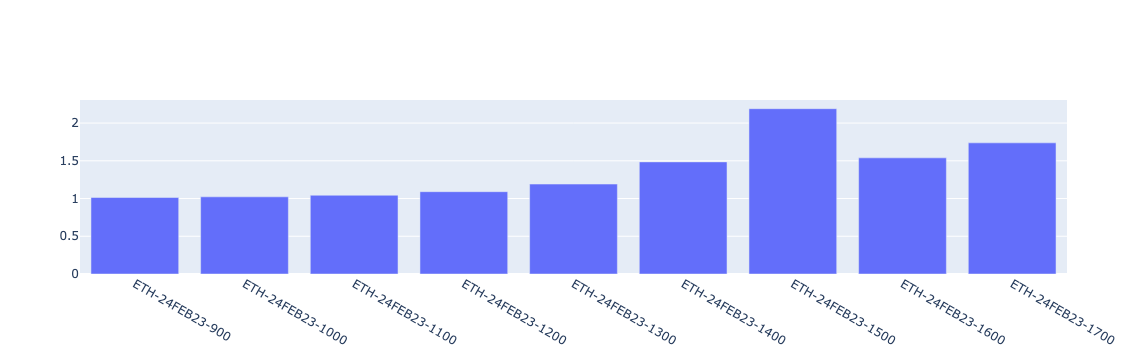

In [217]:
dices2 = pd.DataFrame(np.random.randint(low=1, high=7, size=(100, 2)), columns=('Кость 1', 'Кость 2'))
dices2['Сумма'] = dices2['Кость 1'] + dices2['Кость 2']
dices3 = pd.DataFrame(np.random.randint(low=1, high=7, size=(1000, 2)), columns=('Кость 1', 'Кость 2'))
dices3['Сумма'] = dices3['Кость 1'] + dices3['Кость 2']

fig = go.Figure()
# fig.add_trace(go.Histogram(x=dices['Сумма']))
for i in range(len(res)):
    # fig.add_trace(go.Histogram(x=r))
    # fig.add_trace(go.Histogram(x=r))
    fig2 = px.bar(res[0], x=np.array([res[i][0]]), y=np.array([res[i][1]]))
    
    # fig2 = px.bar(df, x="x", y="y")
    fig.add_trace(fig2.data[0])

# fig.add_trace(go.Histogram(x=dices3['Сумма']))
fig.show()